# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1a485nluGKhZ8GMlCVT0a4Nd7PlmghprS/view?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:


import numpy as np
import time
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.auto import tqdm
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt


In [ ]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The data sets which is constructed with 9 folders which each contains around 800+ sets of images. I think most of the data should be used for image training instead of model testing and parameter tuning whiling still leaving enough for these two. Hence, I choose 60% of the total data goes to training set, 20% goes to both validation set and testing set.

For lab2

In [ ]:
#adapt
def get_data_loader(data_folder, class_num, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
    """

    train_indices, val_indices, test_indices = [], [], []
    count = 0
    for i in class_num:
        train_indices.extend(list(range(count, count + int(i * 0.6))))    # 60% for training
        val_indices.extend(list(range(count + int(i * 0.6), count + int(i * 0.8))))  # 20% for validation
        test_indices.extend(list(range(count + int(i * 0.8), count + i)))  # 20% for testing
        count += i

    np.random.seed(1234)
    np.random.shuffle(train_indices)

    train_sampler = SubsetRandomSampler(train_indices)
    train_loader = torch.utils.data.DataLoader(data_folder, batch_size=batch_size, num_workers=1, sampler=train_sampler)

    val_sampler = SubsetRandomSampler(val_indices)
    val_loader = torch.utils.data.DataLoader(data_folder, batch_size=batch_size, num_workers=1, sampler=val_sampler)

    test_sampler = SubsetRandomSampler(test_indices)
    test_loader = torch.utils.data.DataLoader(data_folder, batch_size=batch_size, num_workers=1, sampler=test_sampler)

    print("60% traing 20% test and val")

    return train_loader, val_loader, test_loader

def get_class_num(directory):
    total = 0
    count_list = []
    for folder in os.listdir(directory):
        count = 0
        f_path = os.path.join(directory, folder)
        for file in os.listdir(f_path):
            count += 1

        print(folder, " ", count)
        total += count
        count_list.append(count)

    print("Total: ", total)
    return count_list






F   236
B   247
C   245
D   247
E   247
G   250
I   249
H   244
A   254
Total:  2219
60% traing 20% test and val


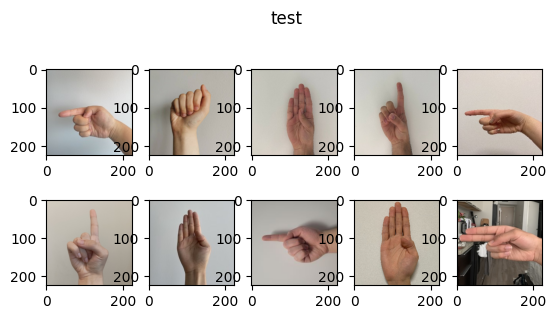

In [ ]:
data_path = "/content/gdrive/MyDrive/here/Lab3_Gestures_Summer"

# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_folder = ImageFolder(data_path, transform=transform)

class_num = get_class_num(data_path)
train_loader, val_loader, test_loader = get_data_loader(data_folder, class_num, 1) #batch = 1 for easy viroualize

plt.figure()
k = 0
for images, labels in test_loader:
    image = images[0]
    img = np.transpose(image, [1, 2, 0])
    # normalize pixel to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k + 1)
    plt.suptitle("test")
    plt.imshow(img)
    #print(first 10)
    k += 1
    if k > 9:
        break


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
#Convolutional Neural Network Architecture

'''
#Convolutional Neural Network Architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "dynamic"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = None
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.view(x.size(0), -1).size(1), 32)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    print('Convolutional Neural Network Architecture Done')

'''

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, 5,stride=3,padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5,stride=2,padding=0)
        self.pool2 = nn.MaxPool2d(stride=3, kernel_size=2) #this speed up real good improve the tut coded
        self.fc1 = nn.Linear(6* 6 * 10, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 6 * 10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


    print('Convolutional Neural Network Architecture Done')



Convolutional Neural Network Architecture Done


 chose a CNN architecture because it is good when working with images. I used two convolutional layers, two pooling layers, and two fully connected layers. I chose to use two convolutional layers to let the model extract abstract features; I used the pooling layers to reduce the dimension of the feature map, causing the model to train faster. The two fully connected layers at the end are used for classification. In addition, the ReLU activation function lets the model learn non-linearity.

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

base on lab2 code example at first but changed to be able to GPU and combined plot and evoluate into one thing removed a lot of code

In [ ]:
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def train(model, train_loader,val_loader, batch_size=64, num_epochs=1, learning_rate = 0.01):
    torch.manual_seed(1234)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, epoch_itr, losses, val_loss, train_acc, val_acc = [], [], [], [], [], []

    # training
    n = 0 # the number of iterations


     #new things
    progress_total = num_epochs * len(train_loader)
    pbar = tqdm(desc = 'while loop', total = progress_total)
    pbar.update(1)

    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save
            iters.append(n)
            losses.append(float(loss)/batch_size)

            # get_accuracy
            pred = out.max(1,keepdim = True)[1]
            correct = pred.eq(labels.view_as(pred)).sum().item()
            total = imgs.shape[0]
            t_acc = correct/ total
            train_acc.append(t_acc) # compute training accuracy
            n += 1
            pbar.update(1)

        val_l = 0
        correct = 0
        total = 0

        #do to val
        for valimgs, vallabels in val_loader:


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              valimgs = valimgs.cuda()
              vallabels = vallabels.cuda()
            #############################################

            output = model(valimgs)
            pred = output.max(1, keepdim=True)[1]
            val_l += criterion(output, vallabels).item()  # compute the total loss
            optimizer.zero_grad()
            correct += pred.eq(vallabels.view_as(pred)).sum().item()
            total += valimgs.shape[0]

        v_acc, v_loss = correct / total, float(val_l)/total

        val_acc.append(v_acc)  # compute validation accuracy
        val_loss.append(v_loss)
        epoch_itr.append(n)

        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds\n".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.plot(epoch_itr, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(epoch_itr, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CrossEntropy Loss is chosen because it is used for multi-class classification tasks.

SGD with Momentum is selected as the optimizer because it is effective and suited for large-scale learning tasks, especially when combined with momentum, which helps improve efficiency and stability.

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

A   3
H   3
G   2
Total:  8
60% traing 20% test and val
CUDA is available!  Training on GPU ...



while loop:   0%|          | 0/30 [00:00<?, ?it/s]

Total time elapsed: 5.94 seconds



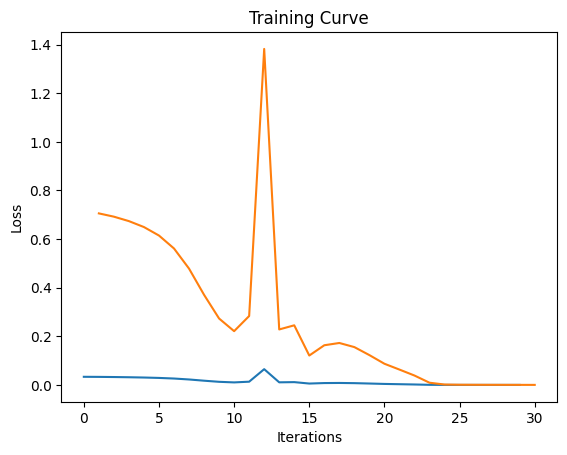

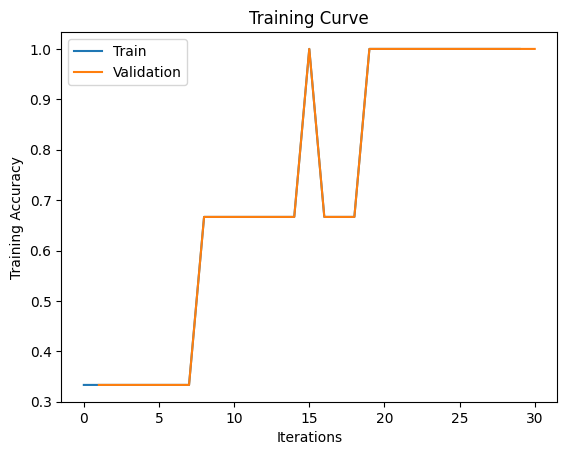

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:


small_path = "/content/gdrive/MyDrive/here/small" #3A,3H, 2G

# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_folder = ImageFolder(small_path , transform=transform)


class_num = get_class_num(small_path) # where bug located
train_loader, val_loader, test_loader = get_data_loader(data_folder, class_num, 8) #3+3+2 = 8

#from tut_3a
use_cuda = True
model = CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')


train(model, train_loader, train_loader, batch_size=64, num_epochs=30, learning_rate = 0.05)



It is clearly shown that after about 20ish interations (not epoch) we reaches a 100% accuracy on the small dataset. This shows that our model has memorized the training data. Hence, it shows that my model and training code is capable of memorizing the labels of this small data set.

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.



base on lab2, my choices are:

larning rate

batch size

number of hidden nerons


### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

let's start with a small batch size and high learning rate (should not be super good)

F   236
B   247
C   245
D   247
E   247
G   250
I   249
H   244
A   254
Total:  2219
60% traing 20% test and val
CUDA is available!  Training on GPU ...



while loop:   0%|          | 0/4440 [00:00<?, ?it/s]

Total time elapsed: 720.75 seconds



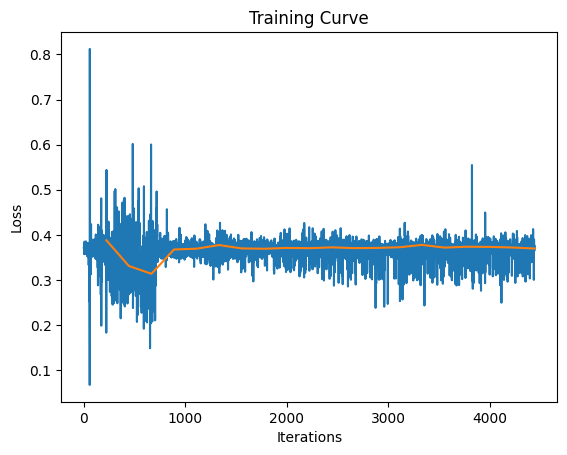

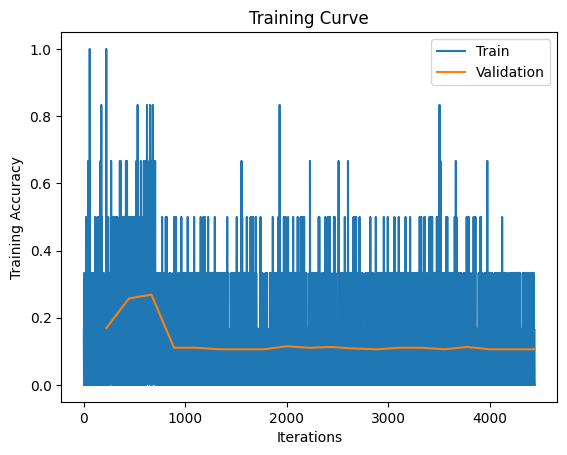

Final Training Accuracy: 0.0
Final Validation Accuracy: 0.10609480812641084


In [ ]:
data_path = "/content/gdrive/MyDrive/here/Lab3_Gestures_Summer"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_folder = ImageFolder(data_path , transform=transform)


class_num = get_class_num(data_path) # where bug located
train_loader, val_loader, test_loader = get_data_loader(data_folder, class_num, 6)

#from tut_3a
use_cuda = True
model = CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')


train(model, train_loader, val_loader, batch_size=6, num_epochs=20, learning_rate = 0.05)

change learning rate

B   247
E   247
D   247
C   245
H   244
F   236
A   254
G   250
I   249
Total:  2219
CUDA is available!  Training on GPU ...

60% traing 20% test and val


while loop:   0%|          | 0/4440 [00:00<?, ?it/s]

Total time elapsed: 294.56 seconds



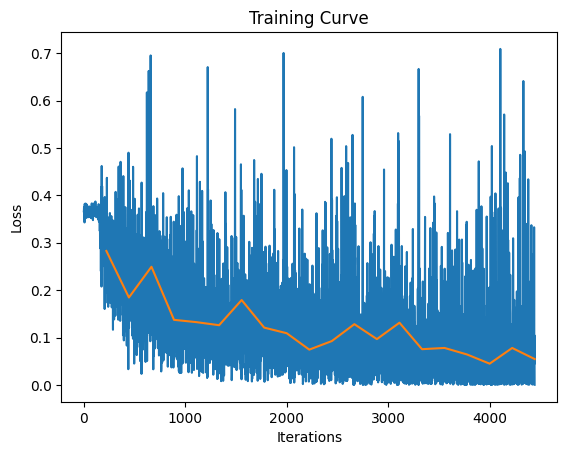

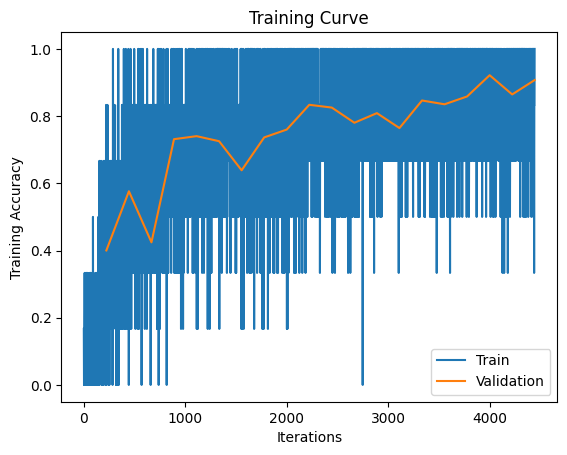

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.90744920993228


In [ ]:
data_path = "/content/gdrive/MyDrive/here/Lab3_Gestures_Summer"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_folder = ImageFolder(data_path , transform=transform)


class_num = get_class_num(data_path) # where bug located

#from tut_3a
use_cuda = True
model = CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')
train_loader, val_loader, test_loader = get_data_loader(data_folder, class_num, 6)


train(model, train_loader, val_loader, batch_size=6, num_epochs=20, learning_rate = 0.01)

ok, it seems to be better

increase batch size

B   247
E   247
D   247
C   245
H   244
F   236
A   254
G   250
I   249
Total:  2219
CUDA is available!  Training on GPU ...

60% traing 20% test and val


while loop:   0%|          | 0/90 [00:00<?, ?it/s]

Total time elapsed: 421.75 seconds



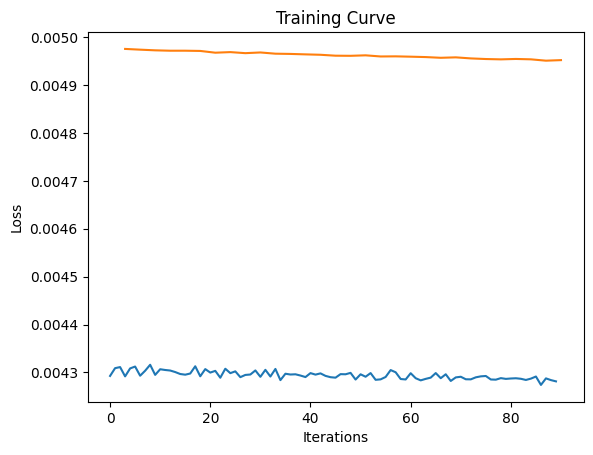

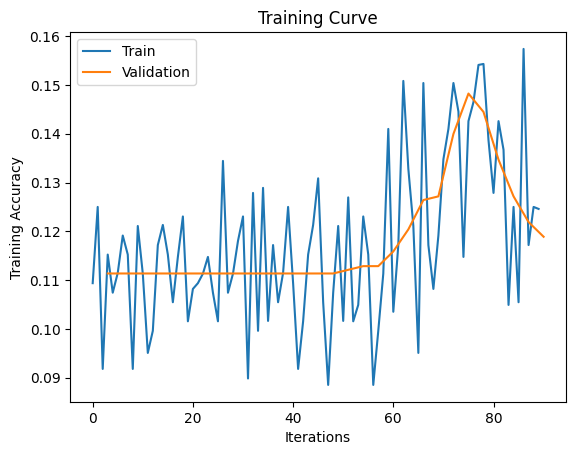

Final Training Accuracy: 0.12459016393442623
Final Validation Accuracy: 0.11888638073739653


In [ ]:
data_path = "/content/gdrive/MyDrive/here/Lab3_Gestures_Summer"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_folder = ImageFolder(data_path , transform=transform)


class_num = get_class_num(data_path) # where bug located

#from tut_3a
use_cuda = True
model = CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')
train_loader, val_loader, test_loader = get_data_loader(data_folder, class_num, 512)


train(model, train_loader, val_loader, batch_size=512, num_epochs=30, learning_rate = 0.01)

Maybe not this big of a batch size

change number of CNN model

In [ ]:
class new(nn.Module):
    def __init__(self):
        super(new, self).__init__()
        self.name = "new"
        self.conv1 = nn.Conv2d(3, 8, 5,stride=3,padding=0) #added 3
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 10, 5,stride=2,padding=0)
        self.pool2 = nn.MaxPool2d(stride=3, kernel_size=2)
        self.fc1 = nn.Linear(6* 6 * 10, 32)
        self.fc2 = nn.Linear(32, 9)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 6 * 10)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

B   247
E   247
D   247
C   245
H   244
F   236
A   254
G   250
I   249
Total:  2219
CUDA is available!  Training on GPU ...

60% traing 20% test and val


while loop:   0%|          | 0/330 [00:00<?, ?it/s]

Total time elapsed: 436.96 seconds



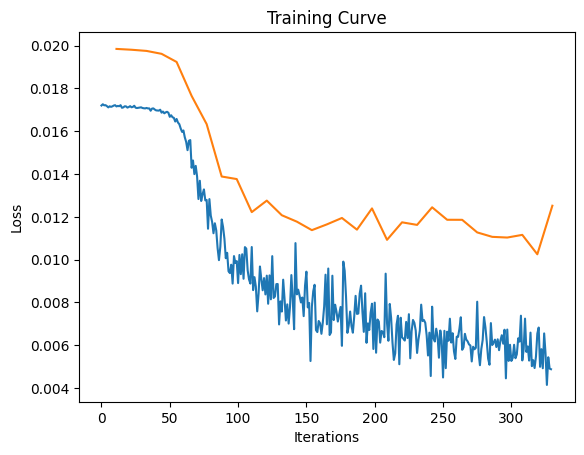

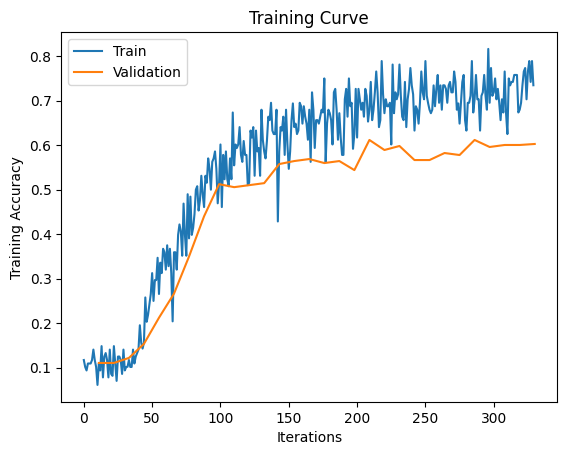

Final Training Accuracy: 0.7346938775510204
Final Validation Accuracy: 0.6027088036117382


In [ ]:
data_path = "/content/gdrive/MyDrive/here/Lab3_Gestures_Summer"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_folder = ImageFolder(data_path , transform=transform)


class_num = get_class_num(data_path) # where bug located

#from tut_3a
use_cuda = True
model = new()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')
train_loader, val_loader, test_loader = get_data_loader(data_folder, class_num, 128)


train(model, train_loader, val_loader, batch_size=128, num_epochs=30, learning_rate = 0.01)

looks like more is good

In [ ]:
class new(nn.Module):
    def __init__(self):
        super(new, self).__init__()
        self.name = "new"
        self.conv1 = nn.Conv2d(3, 10, 5,stride=3,padding=0) #maybe10 this time
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 10, 5,stride=2,padding=0)
        self.pool2 = nn.MaxPool2d(stride=3, kernel_size=2)
        self.fc1 = nn.Linear(6* 6 * 10, 32)
        self.fc2 = nn.Linear(32, 9)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 6 * 10)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

F   236
B   247
C   245
D   247
E   247
G   250
I   249
H   244
A   254
Total:  2219
CUDA is not available.  Training on CPU ...

60% traing 20% test and val


while loop:   0%|          | 0/440 [00:00<?, ?it/s]

Total time elapsed: 859.81 seconds



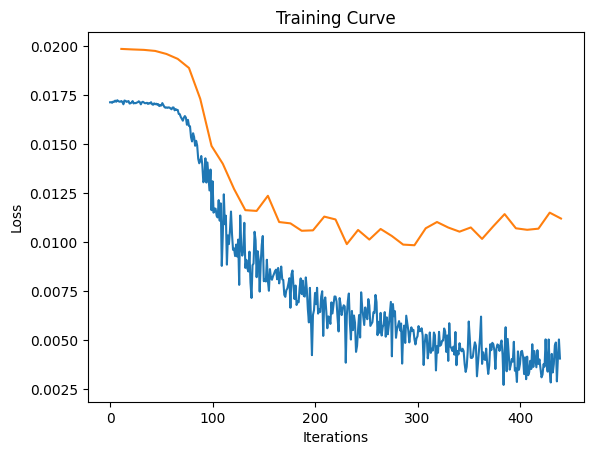

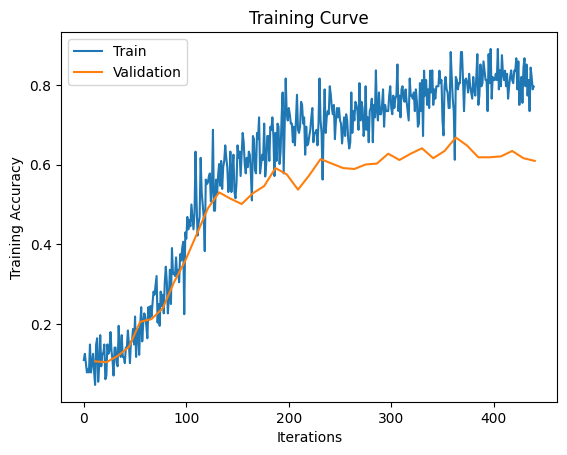

Final Training Accuracy: 0.7959183673469388
Final Validation Accuracy: 0.6094808126410836


In [ ]:
data_path = "/content/gdrive/MyDrive/here/Lab3_Gestures_Summer"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_folder = ImageFolder(data_path , transform=transform)


class_num = get_class_num(data_path) # where bug located

#from tut_3a
use_cuda = True
model = new()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')
train_loader, val_loader, test_loader = get_data_loader(data_folder, class_num, 128)


train(model, train_loader, val_loader, batch_size=128, num_epochs=40, learning_rate = 0.01)

F   236
B   247
C   245
D   247
E   247
G   250
I   249
H   244
A   254
Total:  2219
CUDA is available!  Training on GPU ...

60% traing 20% test and val


while loop:   0%|          | 0/440 [00:00<?, ?it/s]

Total time elapsed: 365.88 seconds



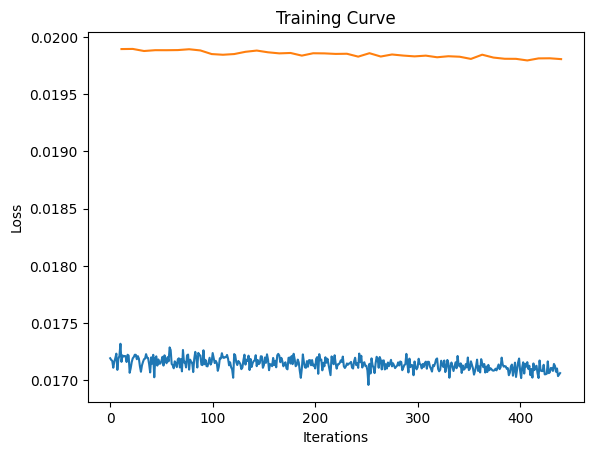

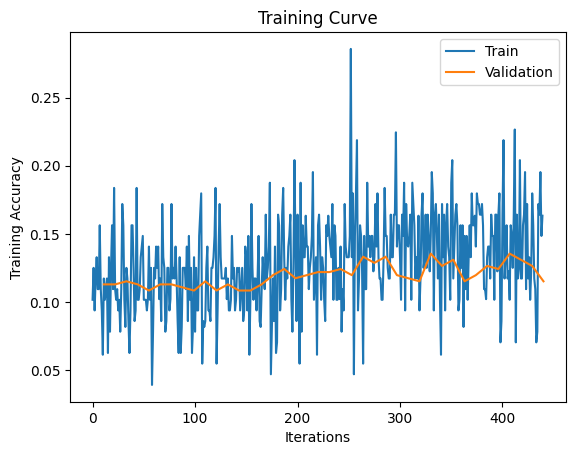

Final Training Accuracy: 0.16326530612244897
Final Validation Accuracy: 0.11512415349887133


In [ ]:
data_path = "/content/gdrive/MyDrive/here/Lab3_Gestures_Summer"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_folder = ImageFolder(data_path , transform=transform)


class_num = get_class_num(data_path) # where bug located

#from tut_3a
use_cuda = True
model = new()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')
train_loader, val_loader, test_loader = get_data_loader(data_folder, class_num, 128)


train(model, train_loader, val_loader, batch_size=128, num_epochs=40, learning_rate = 0.001)

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

The best model is NewNet with batch_size=128, num_epochs=40, learning_rate = 0.01.

Final Training Accuracy: 0.7959183673469388
Final Validation Accuracy: 0.6094808126410836

even though it is not super good but it is the best one out of my tests.


I think maybe adding more nerons can still increase the val accuracy so I think I am on the right track. And base on the curve both val and train is learning.



### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
data_folder = ImageFolder(data_path, transform=transform)
class_num = get_class_num(data_path)
train_loader, val_loader, test_loader = get_data_loader(data_folder, class_num, batch_size=128)
net = new()
net.load_state_dict(torch.load('model_new_bs128_lr0.01_epoch39'))

F   236
B   247
C   245
D   247
E   247
G   250
I   249
H   244
A   254
Total:  2219
60% traing 20% test and val


<ipython-input-10-d0fe359061a6>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('model_new_bs128_lr0.01_epoch39'))


<All keys matched successfully>

In [ ]:
totalr = 0
right = 0
for img, label in test_loader:
    output = net(img)
    pred = output.max(1, keepdim=True)[1]
    right += pred.eq(label.view_as(pred)).sum().item()
    totalr += img.shape[0]

result = right / totalr
print("The test accuracy is {}%".format(result*100))

The test accuracy is 58.836689038031324%


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 48.1MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
#features = alexnet.features(img)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
data_path = "/content/gdrive/MyDrive/here/Lab3_Gestures_Summer"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_folder = ImageFolder(data_path , transform=transform)


data_folder = ImageFolder(data_path, transform=transform)  #can I do that prob no
class_num = get_class_num(data_path)
train_loader, val_loader, test_loader = get_data_loader(data_folder, class_num, batch_size=128)


alex_feature = [[],[],[]]
loader_list = [train_loader, val_loader, test_loader]
for loader in range(len(loader_list)):
    for imgs, labels in loader_list[loader]:
        # alnc_feature[loader]
        feature = alexnet.features(imgs)
        alex_feature[loader].append([torch.from_numpy(feature.detach().numpy()),labels])


F   236
B   247
C   245
D   247
E   247
G   250
I   249
H   244
A   254
Total:  2219
60% traing 20% test and val


KeyboardInterrupt: 

accidently pressed run here again succesful before, stopped manually, should not have returned error here. the following is just based on the previous run.

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
from math import floor
torch.manual_seed(543243)

class AlexNet(nn.Module):
  def __init__(self):
        super(AlexNet, self).__init__()
        self.name = "AlexNet"
        self.fc1 = nn.Linear(6* 6 * 256, 128)
        self.fc2 = nn.Linear(128, 9)
  def forward(self, x):
      x = x.view(-1, 6* 6 * 256)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

I used 2 fully connected layers and 0 convolution and pooling layer because we are using pretrained weights from AlexNet so there is no need for a really deep network and reduce the layer will help with my run time (it takes too long). I choose 128 as the output for conv1 because it feels like a good fit.

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

training takes only one thing now no need for val and train as two inputs

code aobve train and just change to one input state

In [ ]:
def train_new(model, alnc_feature, batch_size=64, num_epochs=1, learning_rate = 0.01):
    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, epoch_itr, losses, val_loss, train_acc, val_acc = [], [], [], [], [], []

    # training
    n = 0 # the number of iterations
    #new
    progress_total = num_epochs * len(alnc_feature[0])
    pbar = tqdm(desc = 'while loop', total = progress_total)
    start_time = time.time()
    for epoch in range(num_epochs):
        # feature_iter = iter(alnc_feature[0])
        # val_feature_iter = iter(alnc_feature[1])
        for imgs, labels in iter(alnc_feature[0]):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                # feature_iter = feature_iter.cuda()
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)

            # get_accuracy
            pred = out.max(1,keepdim = True)[1]
            correct = pred.eq(labels.view_as(pred)).sum().item()
            total = imgs.shape[0]
            t_acc = correct/ total
            # print(t_acc)
            train_acc.append(t_acc) # compute training accuracy

            n += 1
            pbar.update(1)

        val_l = 0
        correct = 0
        total = 0
        for valimgs, vallabels in alnc_feature[1]:


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                # val_feature_iter = val_feature_iter.cuda()
                valimgs = valimgs.cuda()
                vallabels = vallabels.cuda()
            #############################################

            output = model(valimgs)
            pred = output.max(1, keepdim=True)[1]
            val_l += criterion(output, vallabels).item()
            optimizer.zero_grad()
            correct += pred.eq(vallabels.view_as(pred)).sum().item()
            total += valimgs.shape[0]

        v_acc, v_loss = correct / total, float(val_l)/total
        val_acc.append(v_acc)  # compute validation accuracy
        val_loss.append(v_loss)
        epoch_itr.append(n)

        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds\n".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.plot(epoch_itr, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(epoch_itr, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


F   236
B   247
C   245
D   247
E   247
G   250
I   249
H   244
A   254
Total:  2219
CUDA is available!  Training on GPU ...

60% traing 20% test and val


while loop:   0%|          | 0/330 [00:00<?, ?it/s]

Total time elapsed: 1.70 seconds



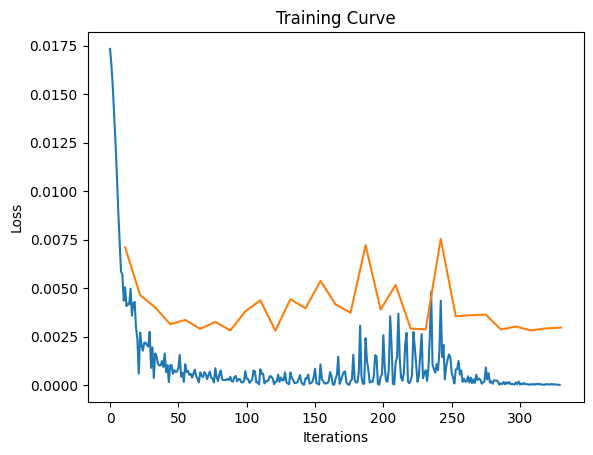

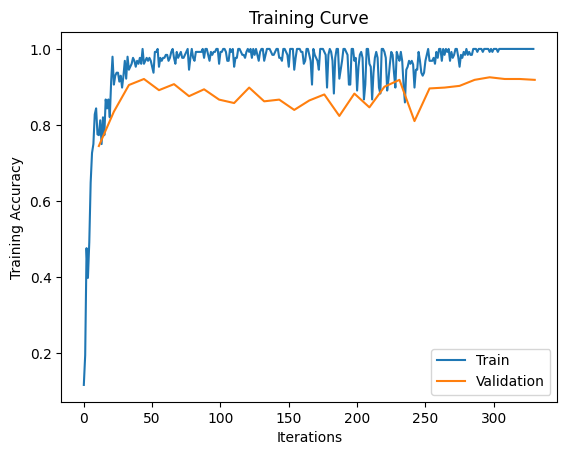

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9187358916478555


In [ ]:
data_path = "/content/gdrive/MyDrive/here/Lab3_Gestures_Summer"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_folder = ImageFolder(data_path , transform=transform)


class_num = get_class_num(data_path) # where bug located

#from tut_3a
use_cuda = True
model = AlexNet()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')
train_loader, val_loader, test_loader = get_data_loader(data_folder, class_num, 128)


train_new(model, alex_feature, batch_size=128, num_epochs=30, learning_rate = 0.01)

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.92

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
data_folder = ImageFolder(data_path, transform=transform)
class_num = get_class_num(data_path)
train_loader, val_loader, test_loader = get_data_loader(data_folder, class_num, batch_size=128)
net = AlexNet()
net.load_state_dict(torch.load('model_AlexNet_bs128_lr0.01_epoch29'))

right = 0
totalr = 0
for img, label in alex_feature[2]:
    output = net(img)
    predic = output.max(1, keepdim=True)[1]
    right += predic.eq(label.view_as(predic)).sum().item()
    totalr += len(img)

test_acc = right / totalr
print("The test accuracy of the best model is {}%".format(test_acc*100))


F   236
B   247
C   245
D   247
E   247
G   250
I   249
H   244
A   254
Total:  2219
60% traing 20% test and val
The test accuracy for the best model is 82.10290827740492%


<ipython-input-54-2fa9cfe437bf>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('model_AlexNet_bs128_lr0.01_epoch29'))


The test accuracy for the "best" model is 82.10

In [ ]:

from ipywidgets import Widget
Widget.close_all()


In [ ]:
!jupyter nbconvert --to html /content/aalab3.ipynb

[NbConvertApp] Converting notebook /content/aalab3.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('metadata' was unexpected)

Failed validating 'additionalProperties' in stream:

On instance['cells'][51]['outputs'][0]:
{'metadata': {'tags': None},
 'name': 'stdout',
 'output_type': 'stream',
 'text': 'F   236\n'
         'B   247\n'
         'C   245\n'
         'D   247\n'
         'E   247\n'
         'G   250\n'
         'I   249\n'
         'H   244\n'
         '...'}
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconver